# Damages - Deep Learning Coursework 2024

The aim of this coursework will be for you to design, implement and test a deep learning architecture to detect and identify damage in images. Digitization allows to make historical pictures and art much more widely available to the public. Many such pictures have suffered some form of damage due to time, storage conditions and the fragility of the original medium. For example, the image below (A) shows an example of a digitized parchment that has suffered significant damage over time.

**The aim of this project is for you to design, implement and evaluate a deep learning model to detect and identify damage present in images.**

<table>
<tr>
<td>
<div>
<img src="./damage_data/image_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
<td>
<div>
<img src="./damage_data/annotation_rgb_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
</tr>
<td><center>(A) Image</center></td><td><center>(B) damage labels</center></td>
</table>
*(Note that the images will only show once you have downloaded the dataset)*


The image labels in this figure (B) identifies a smatter of peeling paint, a large stained area in the bottom left and a missing part on the top left. Each colour in those images corresponds to a different category of damage, including `fold`, `writing` or `burn marks`. You are provided with a dataset of a variety of damaged images, from Parchment to ceramic or wood painting, and detailed annotations of a range of damages.

You are free to use any architecture you prefer, from what we have seen in class. You can decide to use unsupervised pre-training of only supervised end-to-end training - the approach you choose is your choice.

### Hand-in date: Friday 15th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different type of images (content), what type of material, what type of damage? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?.
* Second, check the provided helper functions for loading the data and separate into training and test set and cross-validation.
* Design a network for the task. What output? What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training?
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases.
* If time allows, go back to drawing board and try a more complex, or better, model.
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit ONE zip file on Moodle containing:
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab.
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF.
* your notebook must clearly contains separate cells for:
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model from github/gitlab/any other online storage you like!
  * testing your model on test data.
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model
  * apply the model to the test data
  * analyse and display the results and accuracy
* In addition provide markup cell:
  * containing your student number at the top
  * to describe and motivate your design choices: architecture, pre-processing, training regime
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work

* **Note that you must put your trained model online so that your code can download it.**


### Assessment criteria
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly).
* In order to get a good mark, you will show good understanding of the approach and provide a working solution.
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution.
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance.
* bonus marks for getting high performance, and some more points are to grab for getting the best performance in the class.

### Notes
* You are provided code to isolate the test set and cross validation, make sure to keep the separation clean to ensure proper setting of all hyperparameters.
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one.
* Be mindful of the time!

## Housekeeping

In [76]:
# !pip install gdown pytorch_lightning

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
import pandas as pd
import random
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 243748701
import numpy as np
import matplotlib.pyplot as plt
import gdown
import shutil
from tqdm import tqdm
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Load dataset

We then load the metadata in a dataframe for convenience

In [78]:
# !pwd

In [79]:
# !gdown 1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS -O damages.zip

In [80]:
# set  that to wherever you want to store the data (eg, your Google Drive), choose a persistent location!
root_dir = '.'
data_dir = os.path.join(root_dir, "damage_data")
csv_path = os.path.join(data_dir, 'metadata.csv')

try:
    df = pd.read_csv(csv_path)

except:  # if the dataset has not been downloaded yet, do it.
    zip_path = os.path.join(root_dir, 'damages.zip')
    gdown.download(id='1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS', output=zip_path)
    shutil.unpack_archive(zip_path, root_dir)
    df = pd.read_csv(csv_path)

This dataframe has the paths of where the dataset images and annotation labels are stored, plus classification labels.

In [81]:
df

,id,material,content,image_path,annotation_path,annotation_rgb_path
0,cljmrkz5n341f07clcujw105j,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341f07clcujw...,./damage_data/annotation_path/cljmrkz5n341f07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
1,cljmrkz5n341n07clf1u410ed,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341n07clf1u4...,./damage_data/annotation_path/cljmrkz5n341n07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
2,cljmrkz5n341r07clhl93dpre,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341r07clhl93...,./damage_data/annotation_path/cljmrkz5n341r07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
3,cljmrkz5n341v07cl2gfhd6zj,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341v07cl2gfh...,./damage_data/annotation_path/cljmrkz5n341v07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
4,cljmrkz5n341z07cldbn01un3,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341z07cldbn0...,./damage_data/annotation_path/cljmrkz5n341z07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
...,...,...,...,...,...,...
390,clnofow7i00n2076ubpfodf4d,Wood,Artistic depiction,./damage_data/image_path/clnofow7i00n2076ubpfo...,./damage_data/annotation_path/clnofow7i00n2076...,./damage_data/annotation_rgb_path/clnofow7i00n...
391,clnrm7fvu092q07840tq9zs03,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092q07840tq9...,./damage_data/annotation_path/clnrm7fvu092q078...,./damage_data/annotation_rgb_path/clnrm7fvu092...
392,clnrm7fvu092r0784a6p2m5li,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092r0784a6p2...,./damage_data/annotation_path/clnrm7fvu092r078...,./damage_data/annotation_rgb_path/clnrm7fvu092...
393,clnrm7fvu092s0784tgwccewe,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092s0784tgwc...,./damage_data/annotation_path/clnrm7fvu092s078...,./damage_data/annotation_rgb_path/clnrm7fvu092...


The images in the dataset are categorised in terms of the type of `material`, meaning what was the original picture on, eg, Parchment, Glass or Textile.

In [82]:
df['material'].unique()

array(['Parchment', 'Film emulsion', 'Glass', 'Paper', 'Tesserae',
       'Canvas', 'Textile', 'Ceramic', 'Wood'], dtype=object)

Moreover, images are also categorised in terms on the `content` of the image, meaning what is depicted: eg, Line art, geometric patterns, etc.

In [83]:
df['content'].unique()

array(['Artistic depiction', 'Line art', 'Photographic depiction',
       'Geometric patterns'], dtype=object)

## Labels
Segmentation labels are saved as a PNG image, where each number from 1 to 15 corresponds to a damage class like Peel, Scratch etc; the Background class is set to 255, and the Clean class (no damage) is set to 0. We also provide code to convert these annotation values to RGB colours for nicer visualisation, but for training you should use the original annotations.

In [84]:
name_color_mapping = {
    "Material loss": "#1CE6FF",
    "Peel": "#FF34FF",
    "Dust": "#FF4A46",
    "Scratch": "#008941",
    "Hair": "#006FA6",
    "Dirt": "#A30059",
    "Fold": "#FFA500",
    "Writing": "#7A4900",
    "Cracks": "#0000A6",
    "Staining": "#63FFAC",
    "Stamp": "#004D43",
    "Sticker": "#8FB0FF",
    "Puncture": "#997D87",
    "Background": "#5A0007",
    "Burn marks": "#809693",
    "Lightleak": "#f6ff1b",
}

class_names = [ 'Material loss', 'Peel', 'Dust', 'Scratch',
                'Hair', 'Dirt', 'Fold', 'Writing', 'Cracks', 'Staining', 'Stamp',
                'Sticker', 'Puncture', 'Burn marks', 'Lightleak', 'Background']

class_to_id = {class_name: idx+1 for idx, class_name in enumerate(class_names)}
class_to_id['Background'] = 255  # Set the Background ID to 255

def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

id_to_rgb = {class_to_id[class_name]: hex_to_rgb(color) for class_name, color in name_color_mapping.items()}
id_to_rgb[0] = (0,0,0)

# Create id2label mapping: ID to class name
id2label = {idx: class_name for class_name, idx in class_to_id.items()}

# Create label2id mapping: class name to ID, which is the same as class_to_id
label2id = class_to_id

# Non-damaged pixels
id2label[0] = 'Clean'
label2id['Clean'] = 0

In [85]:
from IPython.display import Markdown

legend='#### Colour labels for each damage type\n'
for damage in class_names:
    legend += '- <span style="color: {color}">{damage}</span>.\n'.format(color=name_color_mapping[damage], damage=damage)
display(Markdown(legend))

#### Colour labels for each damage type
- <span style="color: #1CE6FF">Material loss</span>.
- <span style="color: #FF34FF">Peel</span>.
- <span style="color: #FF4A46">Dust</span>.
- <span style="color: #008941">Scratch</span>.
- <span style="color: #006FA6">Hair</span>.
- <span style="color: #A30059">Dirt</span>.
- <span style="color: #FFA500">Fold</span>.
- <span style="color: #7A4900">Writing</span>.
- <span style="color: #0000A6">Cracks</span>.
- <span style="color: #63FFAC">Staining</span>.
- <span style="color: #004D43">Stamp</span>.
- <span style="color: #8FB0FF">Sticker</span>.
- <span style="color: #997D87">Puncture</span>.
- <span style="color: #809693">Burn marks</span>.
- <span style="color: #f6ff1b">Lightleak</span>.
- <span style="color: #5A0007">Background</span>.


## Create dataset splits

Here is an example of how to split the dataset for Leave-one-out cross validation (LOOCV) based on material.

In [86]:
def create_leave_one_out_splits(df, criterion='material'):

    grouped = df.groupby(criterion)
    content_splits = {name: group for name, group in grouped}
    unique_val = df[criterion].unique()

    # Initialize a dictionary to hold the train and validation sets for each LOOCV iteration
    loocv_splits = {}

    for value in unique_val:
        # Create the validation set
        val_set = content_splits[value]

        # Create the training set
        train_set = pd.concat([content_splits[c] for c in unique_val if c != value])

        # Add these to the loocv_splits dictionary
        loocv_splits[value] = {'train_set': train_set, 'val_set': val_set}

    return loocv_splits


For this coursework, we will want to assess the generalisation of the method, so for that we will keep one type of material (`Canvas`) as test set, and only train on the remaining ones.

In [87]:
# split the dataset according to material type
full_splits = create_leave_one_out_splits(df, 'material')

# use Canvas as test set
test_set = full_splits['Canvas']['val_set']

# use the rest as training set
train_set = full_splits['Canvas']['train_set']

# prepare a leave-one-out cross validation for the training set
loocv_splits = create_leave_one_out_splits(train_set, 'material')

# identify the different type of image content
unique_material = train_set['material'].unique()
print(unique_material)


['Parchment' 'Film emulsion' 'Glass' 'Paper' 'Tesserae' 'Textile'
 'Ceramic' 'Wood']


To help you, here are some helper functions to help crop and process images.

In [88]:
def random_square_crop_params(image, target_size):
    width, height = image.size
    min_edge = min(width, height)

    # Conditionally set the range for random crop size
    lower_bound = min(min_edge, target_size)
    upper_bound = max(min_edge, target_size)

    # Generate crop_size
    crop_size = random.randint(lower_bound, upper_bound)

    # Check and adjust if crop_size is larger than any dimension of the image
    if crop_size > width or crop_size > height:
        crop_size = min(width, height)

    # Generate random coordinates for the top-left corner of the crop
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)

    return (x, y, x + crop_size, y + crop_size)

def apply_crop_and_resize(image, coords, target_size):
    image_crop = image.crop(coords)
    image_crop = image_crop.resize((target_size, target_size), Image.Resampling.NEAREST)
    return image_crop

We also provide a simple class for holding the dataset

In [89]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import numpy as np
from PIL import Image

from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size, is_train=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.is_train = is_train

        self.to_tensor = transforms.ToTensor()

        # Define the normalization transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
            return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        annotation = Image.open(row['annotation_path']).convert('L')
        annotation_rgb = Image.open(row['annotation_rgb_path']).convert('RGB')
        id = row['id']
        material = row['material']
        content = row['content']

        if self.is_train:
            # Generate random square cropping coordinates
            crop_coords = random_square_crop_params(image, self.target_size)

            # Apply the same cropping and resizing to all
            image = apply_crop_and_resize(image, crop_coords, self.target_size)
            annotation = apply_crop_and_resize(annotation, crop_coords, self.target_size)
            annotation_rgb = apply_crop_and_resize(annotation_rgb, crop_coords, self.target_size)
        else:  # Validation
            # Instead of cropping, downsize the images so that the longest edge is 1024 or less
            max_edge = max(image.size)
            if max_edge > 1024:
                downsample_ratio = 1024 / max_edge
                new_size = tuple([int(dim * downsample_ratio) for dim in image.size])

                image = image.resize(new_size, Image.Resampling.BILINEAR)
                annotation = annotation.resize(new_size, Image.Resampling.NEAREST)
                annotation_rgb = annotation_rgb.resize(new_size, Image.Resampling.BILINEAR)

        # Convert PIL images to PyTorch tensors
        image = self.to_tensor(image)
        annotation = torch.tensor(np.array(annotation), dtype=torch.long)
        annotation_rgb = self.to_tensor(annotation_rgb)

        # Normalize the image
        image = self.normalize(image)

        # Change all values in annotation that are 255 to 16
        annotation[annotation == 255] = 16

        return {
            'image': image,
            'annotation': annotation,
            'annotation_rgb': annotation_rgb,
            'id': id,
            'material': material,
            'content': content
        }

Here we create a DataModule which encapsulates our training and validation DataLoaders; you can also do this manually by only using the Pytorch DataLoader class, lines 24 and 27.

In [90]:
from torch.utils.data import DataLoader

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, loocv_splits, current_material, target_size, batch_size=32, num_workers=0):
        super().__init__()
        self.loocv_splits = loocv_splits
        self.current_material = current_material
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Load current train and validation set based on LOOCV iteration
        train_df = self.loocv_splits[self.current_material]['train_set']
        val_df = self.loocv_splits[self.current_material]['val_set'].sample(frac=1).reset_index(drop=True)

        self.train_dataset = CustomDataset(dataframe=train_df, target_size=self.target_size, is_train=True)
        self.val_dataset = CustomDataset(dataframe=val_df, target_size=self.target_size, is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        pass


The following will create a data module for validating on the first content in the list (`Parchment`) and training on all the other types of material (you will want to do that for each fold).

In [91]:
# data_module = CustomDataModule(loocv_splits=loocv_splits,
#                                current_material=unique_material[3], # 0  0-7
#                                target_size=512,
#                                batch_size=4)

Finally, we can get the train and validation data loaders from the data module.

In [92]:
# data_module.setup()
# train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()

# Dataset visualisation

We need to denormalise the images so we can display them

In [93]:
# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_cpy = image.copy()
    for i in range(3):
        img_cpy[..., i] = img_cpy[..., i] * std[i] + mean[i]
    return img_cpy

## Visualise training samples
Random square crops of the images and correspoding RGB annotations on their own and overlaid onto the image.

In [94]:
# example_batch = next(iter(train_loader))

# example_images = example_batch['image']
# example_annotations = example_batch['annotation']
# example_annotation_rgbs = example_batch['annotation_rgb']

# # Number of examples to visualize
# N = min(4, len(example_images))

# fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

# for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
#     ax.set_title(col, fontsize=24)

# for i in range(N):
#     example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
#     example_annotation = Image.fromarray(np.uint8(example_annotations[i].numpy()), 'L')
#     example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C

#     # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
#     alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
#     example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

#     axes[i, 0].imshow(example_image)
#     axes[i, 0].axis('off')

#     #axes[i, 1].imshow(example_annotation, cmap='gray', vmin=0, vmax=255)
#     axes[i, 1].imshow(example_annotation_rgb)
#     axes[i, 1].axis('off')

#     axes[i, 2].imshow(example_image)
#     axes[i, 2].imshow(example_annotation_rgba)
#     axes[i, 2].axis('off')

# plt.tight_layout()
# plt.show()

Visualising the validation set, which loads the left-out class as whole images.

In [95]:
# val_iter = iter(val_loader)
# example_batches = [next(val_iter) for _ in range(4)]

# # Initialize empty lists to collect different parts of each batch
# example_images = []
# example_annotations = []
# example_annotation_rgbs = []
# example_materials = []
# example_contents = []

# # Populate the lists with the data from the 4 batches
# for batch in example_batches:
#     example_images.append(batch['image'].squeeze())
#     example_annotations.append(batch['annotation'].squeeze())
#     example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
#     example_materials.append(batch['material'][0])
#     example_contents.append(batch['content'][0])

# # Number of examples to visualize
# N = min(4, len(example_images))

# fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

# for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
#     ax.set_title(col, fontsize=24)

# for i in range(N):
#     example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
#     example_annotation = example_annotations[i].numpy()
#     example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
#     example_material = example_materials[i]
#     example_content = example_contents[i]
#     # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
#     alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
#     example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))
#     axes[i, 0].imshow(example_image)
#     axes[i, 0].axis('off')

#     axes[i, 1].imshow(example_annotation_rgb)
#     axes[i, 1].axis('off')

#     axes[i, 2].imshow(example_image)
#     axes[i, 2].imshow(example_annotation_rgba)
#     axes[i, 2].axis('off')

# plt.tight_layout()
# plt.show()

# Evaluation

For the final evaluation of the model, make sure to test performance on the left out category, `Canvas` to have a fair idea on how well the model generalises.

In [96]:
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=4)

test_module.setup()

test_loader = test_module.val_dataloader()


In [97]:
def dice_coeff(input, target, reduce_batch_first = False, epsilon = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

my work

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, feature1, feature2):
        diffY = feature2.size()[2] - self.up(feature1).size()[2]
        diffX = feature2.size()[3] - self.up(feature1).size()[3]

        feature1 = F.pad(self.up(feature1), [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([feature2, feature1], dim=1))
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, features=[32,64,128,256]):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, features[0])

        self.down_layers = nn.ModuleList([
            Down(features[i], features[i]*2) for i in range(len(features))
        ])

        self.up_layers = nn.ModuleList([
            Up(features[i]*2, features[i]) for i in reversed(range(len(features)))
        ])

        self.conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        x_down = []
        x_up = []

        x1 = self.inc(x)
        x_down.append(x1)
        x_up.append(x1)

        for down in self.down_layers:
            x = down(x_down[-1])
            x_down.append(x)
            x_up.append(x)

        for idx, up in enumerate(self.up_layers):
            x = up(x_up[-1], x_down.pop(len(self.up_layers)-idx-1))
            x_up.append(x)

        logits = self.conv(x)
        return logits
    
def dice_loss(input, target, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [99]:
def save_model_and_image(model, loss_list, material):
    plt.plot(loss_list)
    plt.title(f'Training Loss {material}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./loss/training_loss_{material}.png')  # 指定保存路径和文件名

    plt.show()  # 显示图像
    
    torch.save(model.state_dict(), f'./pre_trained_model/{material}_model.pth')

  0%|          | 0/83 [00:00<?, ?it/s]

100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [1/15], loss:3.592024326324463


100%|██████████| 83/83 [00:52<00:00,  1.59it/s]


Epoch [2/15], loss:3.3173179626464844


100%|██████████| 83/83 [00:52<00:00,  1.59it/s]


Epoch [3/15], loss:3.0885708332061768


100%|██████████| 83/83 [00:52<00:00,  1.59it/s]


Epoch [4/15], loss:2.909541130065918


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [5/15], loss:2.8253884315490723


100%|██████████| 83/83 [00:52<00:00,  1.59it/s]


Epoch [6/15], loss:2.4875199794769287


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [7/15], loss:2.3589634895324707


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [8/15], loss:2.104707956314087


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [9/15], loss:2.1653482913970947


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [10/15], loss:1.7123281955718994


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [11/15], loss:1.5298302173614502


100%|██████████| 83/83 [00:52<00:00,  1.57it/s]


Epoch [12/15], loss:1.7954847812652588


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [13/15], loss:1.3664944171905518


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [14/15], loss:1.3817169666290283


100%|██████████| 83/83 [00:52<00:00,  1.58it/s]


Epoch [15/15], loss:1.1154088973999023


100%|██████████| 42/42 [00:05<00:00,  7.06it/s]

dice:  tensor(0.7946, device='cuda:0')


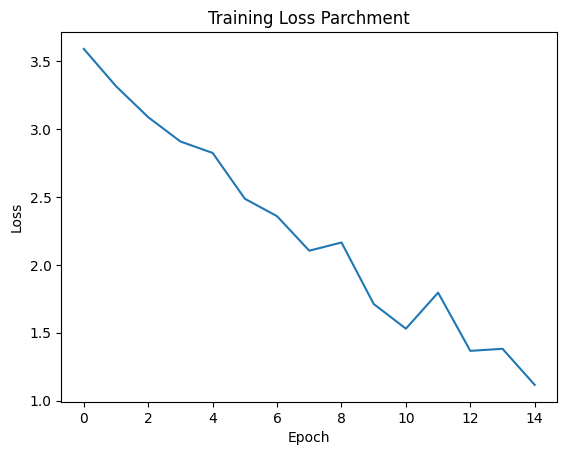

100%|██████████| 88/88 [00:54<00:00,  1.63it/s]


Epoch [1/15], loss:3.481058120727539


100%|██████████| 88/88 [00:53<00:00,  1.64it/s]


Epoch [2/15], loss:3.096892833709717


100%|██████████| 88/88 [00:54<00:00,  1.63it/s]


Epoch [3/15], loss:3.0236330032348633


100%|██████████| 88/88 [00:53<00:00,  1.63it/s]


Epoch [4/15], loss:2.6620030403137207


100%|██████████| 88/88 [00:53<00:00,  1.65it/s]


Epoch [5/15], loss:2.6264894008636475


100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch [6/15], loss:2.2419583797454834


100%|██████████| 88/88 [00:52<00:00,  1.66it/s]


Epoch [7/15], loss:2.097137451171875


100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch [8/15], loss:2.3093245029449463


100%|██████████| 88/88 [00:53<00:00,  1.65it/s]


Epoch [9/15], loss:1.9176808595657349


100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch [10/15], loss:1.7862203121185303


100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch [11/15], loss:1.387593150138855


100%|██████████| 88/88 [00:53<00:00,  1.65it/s]


Epoch [12/15], loss:1.2684330940246582


100%|██████████| 88/88 [00:52<00:00,  1.66it/s]


Epoch [13/15], loss:1.5973091125488281


100%|██████████| 88/88 [00:52<00:00,  1.67it/s]


Epoch [14/15], loss:0.976164698600769


100%|██████████| 88/88 [00:53<00:00,  1.66it/s]


Epoch [15/15], loss:1.6877343654632568


100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


dice:  tensor(0.8636, device='cuda:0')


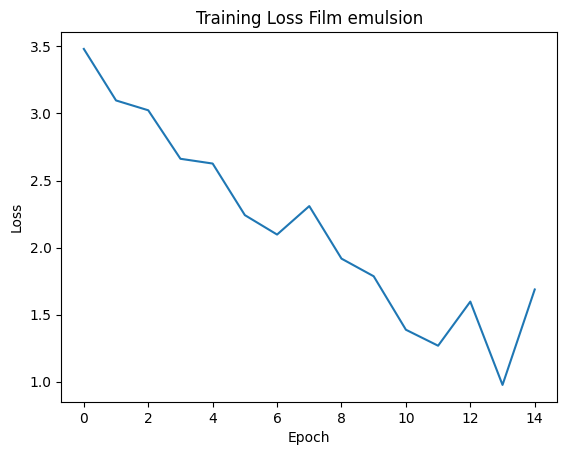

100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [1/15], loss:3.306781053543091


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [2/15], loss:2.838827133178711


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [3/15], loss:2.555467128753662


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [4/15], loss:2.6299312114715576


100%|██████████| 84/84 [00:49<00:00,  1.70it/s]


Epoch [5/15], loss:2.0910043716430664


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [6/15], loss:1.775002360343933


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [7/15], loss:1.755348563194275


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [8/15], loss:1.5669496059417725


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [9/15], loss:1.179988145828247


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [10/15], loss:1.0330984592437744


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [11/15], loss:1.1921309232711792


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [12/15], loss:0.8877390623092651


100%|██████████| 84/84 [00:49<00:00,  1.70it/s]


Epoch [13/15], loss:1.2545053958892822


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [14/15], loss:0.6098450422286987


100%|██████████| 84/84 [00:49<00:00,  1.69it/s]


Epoch [15/15], loss:0.7215746641159058


100%|██████████| 39/39 [00:07<00:00,  4.91it/s]


dice:  tensor(0.7163, device='cuda:0')


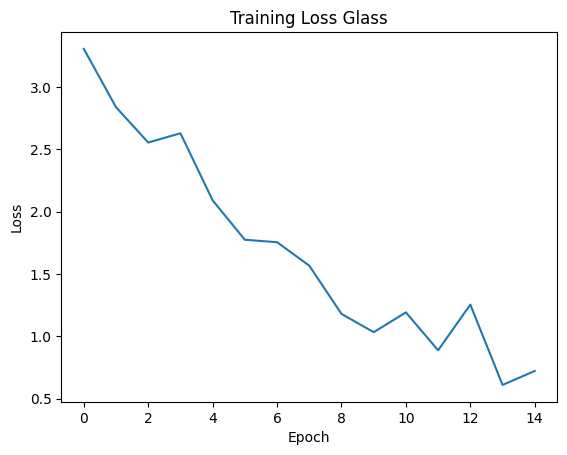

100%|██████████| 47/47 [00:28<00:00,  1.63it/s]


Epoch [1/15], loss:3.663660764694214


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [2/15], loss:3.5058321952819824


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [3/15], loss:3.3203611373901367


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [4/15], loss:3.1957204341888428


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [5/15], loss:3.0270237922668457


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [6/15], loss:2.88293194770813


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [7/15], loss:2.750067710876465


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [8/15], loss:2.7877776622772217


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [9/15], loss:2.605039596557617


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [10/15], loss:2.3867406845092773


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [11/15], loss:2.372382879257202


100%|██████████| 47/47 [00:28<00:00,  1.65it/s]


Epoch [12/15], loss:2.172745704650879


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [13/15], loss:2.679574489593506


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [14/15], loss:2.319722890853882


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Epoch [15/15], loss:3.0273499488830566


100%|██████████| 187/187 [00:33<00:00,  5.56it/s]


dice:  tensor(0.8021, device='cuda:0')


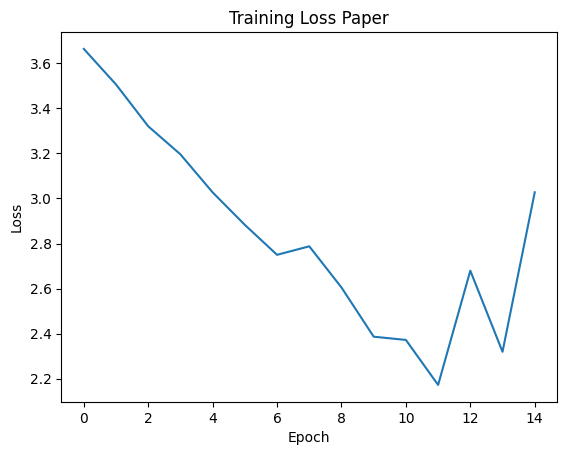

100%|██████████| 86/86 [00:52<00:00,  1.65it/s]


Epoch [1/15], loss:3.1250672340393066


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [2/15], loss:2.7723443508148193


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [3/15], loss:2.4628663063049316


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [4/15], loss:2.4681222438812256


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [5/15], loss:2.2590160369873047


100%|██████████| 86/86 [00:52<00:00,  1.65it/s]


Epoch [6/15], loss:1.9687697887420654


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [7/15], loss:1.6519966125488281


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [8/15], loss:1.9863026142120361


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [9/15], loss:1.2633546590805054


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [10/15], loss:1.4898120164871216


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [11/15], loss:1.1816438436508179


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [12/15], loss:0.8798437118530273


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epoch [13/15], loss:0.9357176423072815


100%|██████████| 86/86 [00:51<00:00,  1.65it/s]


Epoch [14/15], loss:0.9448106288909912


100%|██████████| 86/86 [00:51<00:00,  1.65it/s]


Epoch [15/15], loss:0.6557822823524475


100%|██████████| 30/30 [00:05<00:00,  5.96it/s]

dice:  tensor(0.8708, device='cuda:0')


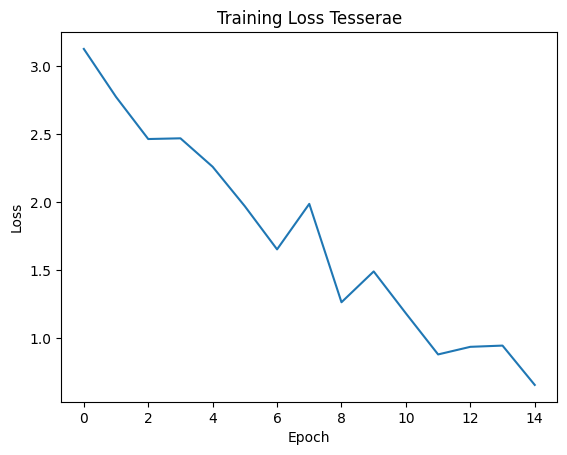

100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [1/15], loss:3.1999306678771973


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [2/15], loss:2.9599573612213135


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [3/15], loss:2.802927017211914


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [4/15], loss:2.3933229446411133


100%|██████████| 89/89 [00:52<00:00,  1.68it/s]


Epoch [5/15], loss:2.299935817718506


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [6/15], loss:2.1081013679504395


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [7/15], loss:1.9181923866271973


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [8/15], loss:1.5813263654708862


100%|██████████| 89/89 [00:54<00:00,  1.63it/s]


Epoch [9/15], loss:1.7229537963867188


100%|██████████| 89/89 [00:53<00:00,  1.66it/s]


Epoch [10/15], loss:1.7341578006744385


100%|██████████| 89/89 [00:53<00:00,  1.66it/s]


Epoch [11/15], loss:1.3436497449874878


100%|██████████| 89/89 [00:53<00:00,  1.66it/s]


Epoch [12/15], loss:1.385803461074829


100%|██████████| 89/89 [00:53<00:00,  1.67it/s]


Epoch [13/15], loss:1.1002908945083618


100%|██████████| 89/89 [00:53<00:00,  1.67it/s]


Epoch [14/15], loss:1.1030359268188477


100%|██████████| 89/89 [00:52<00:00,  1.69it/s]


Epoch [15/15], loss:1.0263721942901611


100%|██████████| 16/16 [00:04<00:00,  3.95it/s]

dice:  tensor(0.8516, device='cuda:0')


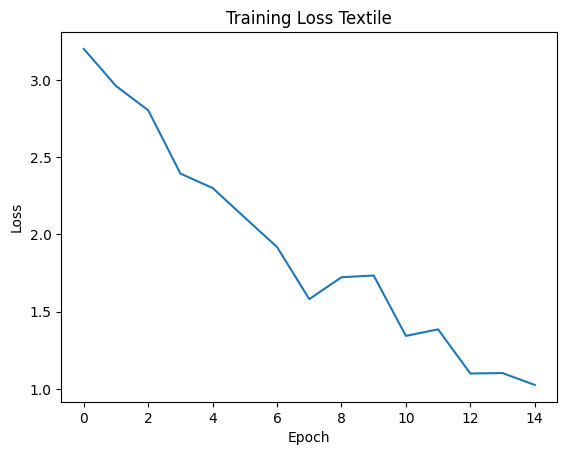

100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [1/15], loss:3.6355838775634766


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [2/15], loss:3.371727705001831


100%|██████████| 91/91 [00:54<00:00,  1.65it/s]


Epoch [3/15], loss:3.169279098510742


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [4/15], loss:2.959573268890381


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [5/15], loss:2.891632556915283


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [6/15], loss:2.797783136367798


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [7/15], loss:2.4632556438446045


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [8/15], loss:2.3764989376068115


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [9/15], loss:2.3796372413635254


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [10/15], loss:2.104039430618286


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [11/15], loss:1.9088168144226074


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [12/15], loss:1.5652226209640503


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch [13/15], loss:1.3738816976547241


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [14/15], loss:1.670621633529663


100%|██████████| 91/91 [00:55<00:00,  1.65it/s]


Epoch [15/15], loss:1.9956371784210205


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


dice:  tensor(0.7312, device='cuda:0')


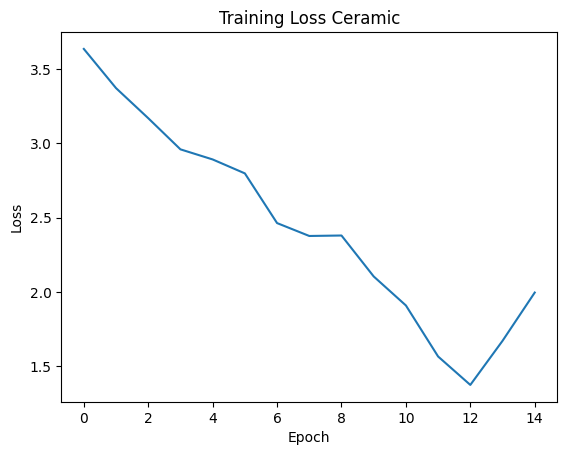

100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch [1/15], loss:3.447587490081787


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [2/15], loss:3.1939311027526855


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [3/15], loss:2.850356101989746


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [4/15], loss:2.4820775985717773


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [5/15], loss:2.389800786972046


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch [6/15], loss:2.226168155670166


100%|██████████| 87/87 [00:49<00:00,  1.74it/s]


Epoch [7/15], loss:2.0143628120422363


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch [8/15], loss:1.8294498920440674


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [9/15], loss:1.6502928733825684


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [10/15], loss:1.50429105758667


100%|██████████| 87/87 [00:49<00:00,  1.74it/s]


Epoch [11/15], loss:1.4535400867462158


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [12/15], loss:2.2372403144836426


100%|██████████| 87/87 [00:50<00:00,  1.74it/s]


Epoch [13/15], loss:1.2824106216430664


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch [14/15], loss:1.0599396228790283


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch [15/15], loss:1.0405197143554688


100%|██████████| 26/26 [00:07<00:00,  3.52it/s]

dice:  tensor(0.8606, device='cuda:0')


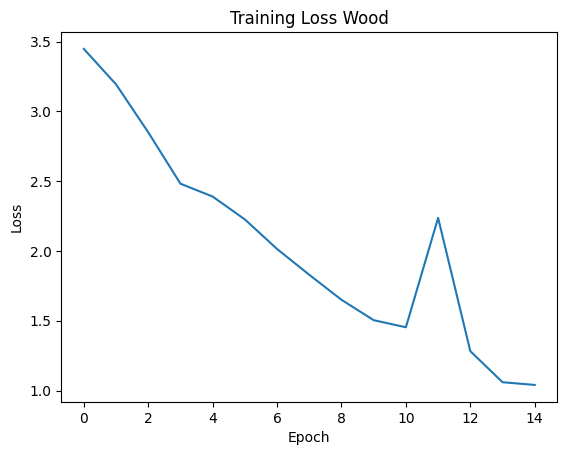

In [100]:
for i, material in enumerate(unique_material):
    data_module = CustomDataModule(loocv_splits=loocv_splits,
                                current_material=unique_material[i], # 0  0-7
                                target_size=512,
                                batch_size=4)

    data_module.setup()
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    output_channels = len(id_to_rgb)
    num_epochs = 15


    model = UNet(3,output_channels).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    loss_list = []
    for epoch in range(num_epochs):
        for data in tqdm(train_loader):
            image = data['image'].to(DEVICE)
            annotation = data['annotation'].to(DEVICE)
            optimizer.zero_grad()

            recon = model(image)
            loss = criterion(recon, annotation)
            loss += dice_loss(
                                F.softmax(recon, dim=1).float(),
                                F.one_hot(annotation, 17).permute(0, 3, 1, 2).float(),
                                multiclass=True
                            )
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        loss_list.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], loss:{loss.item()}')

    model.eval()
    dice_score = 0
    # iterate over the validation set
    with torch.no_grad():
        for batch in tqdm(val_loader):
            image = batch['image'].to(DEVICE)
            mask_true = batch['annotation'].to(DEVICE)

            # move images and labels to correct device and type
            image = image.to(device=DEVICE)
            mask_true = mask_true.to(device=DEVICE)
        
            # predict the mask
            mask_pred = model(image)
            
            # convert to one-hot format
            mask_true = F.one_hot(mask_true, 17).permute(0, 3, 1, 2).float()
            mask_pred = F.one_hot(mask_pred.argmax(dim=1), 17).permute(0, 3, 1, 2).float()
            # compute the Dice score, ignoring background
            dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    print("dice: ", dice_score / max(len(val_loader), 1))

    save_model_and_image(model, loss_list, material)

In [101]:
# model.eval()
# dice_score = 0
# # iterate over the validation set
# with torch.no_grad():
#     for batch in tqdm(test_loader):
#         image = batch['image'].to(DEVICE)
#         mask_true = batch['annotation'].to(DEVICE)

#         # move images and labels to correct device and type
#         image = image.to(device=DEVICE)
#         mask_true = mask_true.to(device=DEVICE)
       
#         # predict the mask
#         mask_pred = model(image)
        
#         # convert to one-hot format
#         mask_true = F.one_hot(mask_true, 17).permute(0, 3, 1, 2).float()
#         mask_pred = F.one_hot(mask_pred.argmax(dim=1), 17).permute(0, 3, 1, 2).float()
#         # compute the Dice score, ignoring background
#         dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

# print("dice: ", dice_score / max(len(test_loader), 1))

In [102]:
        

    # model.eval()
    # dice_score = 0
    # # iterate over the validation set
    # with torch.no_grad():
    #     for batch in tqdm(val_loader):
    #         image = batch['image'].to(DEVICE)
    #         mask_true = batch['annotation'].to(DEVICE)

    #         # move images and labels to correct device and type
    #         image = image.to(device=DEVICE)
    #         mask_true = mask_true.to(device=DEVICE)
        
    #         # predict the mask
    #         mask_pred = model(image)
            
    #         # convert to one-hot format
    #         mask_true = F.one_hot(mask_true, 17).permute(0, 3, 1, 2).float()
    #         mask_pred = F.one_hot(mask_pred.argmax(dim=1), 17).permute(0, 3, 1, 2).float()
    #         # compute the Dice score, ignoring background
    #         dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    # print("dice: ", dice_score / max(len(val_loader), 1))

In [103]:
# utils
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=4)

test_module.setup()

test_loader = test_module.val_dataloader()

def show_loss(loss_list, pre_trained_model_path):
    name = pre_trained_model_path.split('.')[0]
    plt.plot(loss_list)
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()  # 显示图像

In [104]:
# Test pre-trained model
pre_trained_model = UNet(3, 17).to(DEVICE)

'''
    Available model : 
    Ceramic_model.pth, Film emulsion_model.pth, 
    Glass_model.pth, Paper_model.pth
    Parchment_model.pth, Tesserae_model.pth, 
    Textile_model.pth, Wood_model.pth
'''

pre_trained_model_path = './pre_trained_model/Ceramic_model.pth'
pre_trained_model.load_state_dict(torch.load(pre_trained_model_path))
pre_trained_model.eval()
dice_score = 0
# iterate over the validation set
with torch.no_grad():
    for batch in tqdm(test_loader):
        image = batch['image'].to(DEVICE)
        mask_true = batch['annotation'].to(DEVICE)

        # move images and labels to correct device and type
        image = image.to(device=DEVICE)
        mask_true = mask_true.to(device=DEVICE)
       
        # predict the mask
        mask_pred = pre_trained_model(image)
        
        # convert to one-hot format
        mask_true = F.one_hot(mask_true, 17).permute(0, 3, 1, 2).float()
        mask_pred = F.one_hot(mask_pred.argmax(dim=1), 17).permute(0, 3, 1, 2).float()
        # compute the Dice score, ignoring background
        dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

print("dice: ", dice_score.item() / max(len(test_loader), 1))

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:07<00:00,  2.91it/s]

dice:  0.8722826086956522
